In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

# Default bounding box: a rectangle around Lion Yard, Cambridge
_wms_default_bbox = (544970,258280,545170,258480)


def request_wms_boreholes(bbox=_wms_default_bbox, width=1, height=1, i=0, j=0, feature_count=1000):
    # This function builds a standard WMS query for one notional pixel in the search area
    
    bbox_string = ','.join([str(coord_num) for coord_num in bbox])
    
    request_params = {
        'SERVICE': 'WMS',
        'VERSION': '1.3.0',
        'REQUEST': 'GetFeatureInfo',
        'BBOX': bbox_string,
        'CRS': 'EPSG:27700',
        'WIDTH': str(width),
        'HEIGHT': str(height),
        'LAYERS': 'Borehole.records',
        'STYLES': '',
        'FORMAT': 'image/png',
        'QUERY_LAYERS': 'Borehole.records',
        'INFO_FORMAT': 'text/html',
        'I': str(i),
        'J': str(j),
        'FEATURE_COUNT': str(feature_count)
    }

    req_prefix = 'https://map.bgs.ac.uk/arcgis/services/GeoIndex_Onshore/boreholes/MapServer/WmsServer?'
    req_string = '&'.join(["{k}={v}".format(k=k, v=v) for (k, v) in request_params.items()])

    http_result = requests.get(req_prefix + req_string)
    return pd.read_html(http_result.text)[0]

def generate_grid(easting_point_list, northing_point_list, segments=6):    
    # This function takes any bounding polygon and splits it into a grid of near-square "pixels" (for WMS purposes)
    
    max_easting = max(easting_point_list)
    max_northing = max(northing_point_list)
    min_easting = min(easting_point_list)
    min_northing = min(northing_point_list)

    height_northing = max_northing - min_northing
    width_easting = max_easting - min_easting

    height = round(height_northing / (height_northing + width_easting) * segments)
    width = segments - height

    box_size_h = round(height_northing / height, 2)
    box_size_w = round(width_easting / width, 2)
    
    return {'bbox': (min_easting, min_northing, max_easting, max_northing), 'width': width, 'height': height}

_default_segments = 11 # discretization density parameters. _default_segments=11 would allow 3x8, 4x7, 5x6 grids etc
def multiquery_unique_boreholes(easting_point_list, northing_point_list, segments=_default_segments):
    # Takes a polygon defined by eastings and northings (Ordnance Survey grid)
    # and queries BGS WMS using the two functions above
    
    g_dict = generate_grid(easting_point_list, northing_point_list, segments)

    boreholes_df_list = list()

    for i in range(0, g_dict['width']):
        for j in range(0, g_dict['height']):
            boreholes_df_list.append(
                request_wms_boreholes(g_dict['bbox'], g_dict['width'], g_dict['height'], i, j)
            )

    boreholes_df = pd.concat(boreholes_df_list).drop_duplicates(
        keep='first', 
        subset=['REFERENCE', 'ID', 'EASTING', 'NORTHING', 'SCAN_URL', 'AGS_LOG_URL']
    )
    
    boreholes_df.reset_index(inplace=True, drop=True)
    
    return boreholes_df


def boreholes_live(easting_point_list, northing_point_list, segments=_default_segments):
    # Queries BGS WMS for boreholes, then take intersection with the original bounding polygon
    # because WMS pixels are fuzzy and the WMS query area needs to be wider than the actual 
    # desired search area to ensure WMS gives us all the required entries.
    # This step then throws away WMS replies that fall outside the desired polygon area.
    
    boreholes_df = multiquery_unique_boreholes(easting_point_list, northing_point_list, segments)
    boreholes_gdf = gpd.GeoDataFrame(
        boreholes_df,
        geometry=gpd.points_from_xy(boreholes_df.EASTING, boreholes_df.NORTHING),
        crs='EPSG:27700'
    )
    polygon_geom = Polygon(zip(easting_point_list, northing_point_list))
    polygon_series = gpd.GeoSeries(polygon_geom, crs='EPSG:27700')
    polygon_gdf = gpd.GeoDataFrame({'geometry': polygon_series})
    return boreholes_gdf.overlay(polygon_gdf, how='intersection')




32


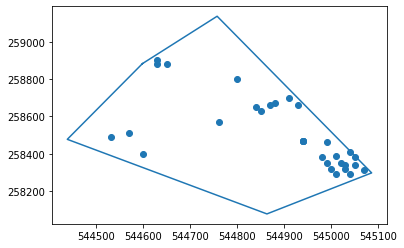

In [2]:
# Case study is an area around Lion Yard, Cambridge
easting_point_list = [544598,544757,545086,544863,544438]
northing_point_list = [258883,259137,258297,258077,258477]
boreholes_gdf = boreholes_live(easting_point_list, northing_point_list)

print(len(boreholes_gdf))

# Plot locations of entries returned by WMS, after filtering, to check that the boreholes do fall within desired area
plt.scatter(boreholes_gdf['EASTING'].tolist(), boreholes_gdf['NORTHING'].tolist())
plt.plot(easting_point_list + [easting_point_list[0]], northing_point_list + [northing_point_list[0]])
plt.show()

# Check the results yourself using BGS GeoIndex!

In [3]:
pd.set_option('display.max_colwidth', 200)
boreholes_gdf

,REFERENCE,NAME,GRID_REF,EASTING,NORTHING,PRECISION,LENGTH,YEAR_KNOWN,SITEREPORT,HELD_AT,ID,Shape,LENGTH_SCAN_CAT,BGS_ID,DATE_UPDATED,SCAN_URL,AGS_LOG_URL,geometry
0,TL45NW151,"JESUS LANE, CAMBRIDGE",TL 44800 58800,544800,258800,&plusmn; 100 METRES,36.57,Null,Null,WLKW,542492,Point,3_Y,542492,22/01/2013 18:07:18,http://scans.bgs.ac.uk/sobi_scans/boreholes/542492,Null,POINT (544800.000 258800.000)
1,TL45NW277,TRINITY COLLEGE MATTHEWS SITE CAMBRIDGE TP D,TL 44910 58700,544910,258700,&plusmn; 10 METRES,2.05,1967,40299,KW,16130868,Point,1_Y,16130868,18/05/2010 13:38:51,http://scans.bgs.ac.uk/sobi_scans/boreholes/16130868,Null,POINT (544910.000 258700.000)
2,TL45NW32,ST.JOHNS COLLEGE CAMBRIDGE 6A,TL 44630 58880,544630,258880,&plusmn; 10 METRES,12.19,Null,Null,KW,542373,Point,2_Y,542373,22/01/2013 18:07:17,http://scans.bgs.ac.uk/sobi_scans/boreholes/542373,Null,POINT (544630.000 258880.000)
3,TL45NW33,ST.JOHNS COLLEGE CAMBRIDGE 6C,TL 44650 58880,544650,258880,&plusmn; 10 METRES,12.19,Null,Null,KW,542374,Point,2_Y,542374,22/01/2013 18:07:17,http://scans.bgs.ac.uk/sobi_scans/boreholes/542374,Null,POINT (544650.000 258880.000)
4,TL45NW31,ST.JOHNS COLLEGE CAMBRIDGE 5C,TL 44630 58900,544630,258900,&plusmn; 10 METRES,12.19,Null,Null,KW,542372,Point,2_Y,542372,22/01/2013 18:07:17,http://scans.bgs.ac.uk/sobi_scans/boreholes/542372,Null,POINT (544630.000 258900.000)
5,TL45NW129,"TRINITY COLLEGE, BARTON ROAD",TL 44760 58570,544760,258570,&plusmn; 10 METRES,69.18,Null,Null,WLKW,542470,Point,3_Y,542470,22/01/2013 18:07:17,http://scans.bgs.ac.uk/sobi_scans/boreholes/542470,Null,POINT (544760.000 258570.000)
6,TL45NW275,TRINITY COLLEGE MATTHEWS SITE CAMBRIDGE TP A,TL 44840 58650,544840,258650,&plusmn; 10 METRES,1.67,1967,40299,KW,16130866,Point,1_Y,16130866,18/05/2010 13:38:51,http://scans.bgs.ac.uk/sobi_scans/boreholes/16130866,Null,POINT (544840.000 258650.000)
7,TL45NW273,TRINITY COLLEGE MATTHEWS SITE CAMBRIDGE 2,TL 44850 58630,544850,258630,&plusmn; 10 METRES,9.14,1967,40299,KW,16130864,Point,1_Y,16130864,18/05/2010 13:38:51,http://scans.bgs.ac.uk/sobi_scans/boreholes/16130864,Null,POINT (544850.000 258630.000)
8,TL45NW272,TRINITY COLLEGE MATTHEWS SITE CAMBRIDGE 1,TL 44870 58660,544870,258660,&plusmn; 10 METRES,18.28,1967,40299,KW,16130863,Point,2_Y,16130863,18/05/2010 13:38:51,http://scans.bgs.ac.uk/sobi_scans/boreholes/16130863,Null,POINT (544870.000 258660.000)
9,TL45NW276,TRINITY COLLEGE MATTHEWS SITE CAMBRIDGE TP C,TL 44880 58670,544880,258670,&plusmn; 10 METRES,4.26,1967,40299,KW,16130867,Point,1_Y,16130867,18/05/2010 13:38:51,http://scans.bgs.ac.uk/sobi_scans/boreholes/16130867,Null,POINT (544880.000 258670.000)


In [4]:
# These URLs are clickable in Jupyter
print(boreholes_gdf.SCAN_URL)

0       http://scans.bgs.ac.uk/sobi_scans/boreholes/542492
1     http://scans.bgs.ac.uk/sobi_scans/boreholes/16130868
2       http://scans.bgs.ac.uk/sobi_scans/boreholes/542373
3       http://scans.bgs.ac.uk/sobi_scans/boreholes/542374
4       http://scans.bgs.ac.uk/sobi_scans/boreholes/542372
5       http://scans.bgs.ac.uk/sobi_scans/boreholes/542470
6     http://scans.bgs.ac.uk/sobi_scans/boreholes/16130866
7     http://scans.bgs.ac.uk/sobi_scans/boreholes/16130864
8     http://scans.bgs.ac.uk/sobi_scans/boreholes/16130863
9     http://scans.bgs.ac.uk/sobi_scans/boreholes/16130867
10      http://scans.bgs.ac.uk/sobi_scans/boreholes/542359
11      http://scans.bgs.ac.uk/sobi_scans/boreholes/542360
12      http://scans.bgs.ac.uk/sobi_scans/boreholes/542542
13    http://scans.bgs.ac.uk/sobi_scans/boreholes/16130865
14    http://scans.bgs.ac.uk/sobi_scans/boreholes/17085549
15      http://scans.bgs.ac.uk/sobi_scans/boreholes/542554
16      http://scans.bgs.ac.uk/sobi_scans/boreholes/5425